This code is using the model from Testing.ipynb, but is adapted for using Reddit input features (age, # posts/comments, score, upvotes, etc.), rather than Twitter input data, such that we train a new version of the model on this data.

In [20]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt

from keras.models import Model
from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Dense, LSTM, Dense, Input, concatenate

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
# load in pretrained model and inspect architecture
loaded_model = tf.keras.models.load_model('my_model.h5', compile=False)
loaded_model.load_weights('my_model.h5')

loaded_model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

loaded_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_1 (Dense)             (None, 500)               5500      
                                                                 
 dense_2 (Dense)             (None, 200)               100200    
                                                                 
 dense_3 (Dense)             (None, 1)                 201       
                                                                 
Total params: 105901 (413.68 KB)
Trainable params: 105901 (413.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [4]:
# load in data
df = pd.read_csv("data/combined_accounts.csv")
df = df.rename(columns={"label": "BotOrNot"})
df = df.sample(frac=1).reset_index(drop=True) # shuffle

# create train/test split
split = int(df.shape[0] * 0.8)
df_train = df.drop('username', axis=1).iloc[:split]
df_test = df.drop('username', axis=1).iloc[split:]

# standardize relevant columns (adjusted for Reddit features)
st_col = [
    "account_age", "post_count", "comment_count",
    "avg_post_score", "avg_comment_score", "total_post_score",
    "total_comment_score", "post_to_comment_ratio",
    "avg_post_length", "avg_comment_length",
]

# obtain mean and std of relevant columns
df_train_mean = df_train[st_col].mean()
df_train_std = df_train[st_col].std()

# apply standardization to relevant columns of train/test data
df_train[st_col] = (df_train[st_col] - df_train_mean) / df_train_std
df_test[st_col] = (df_test[st_col] - df_train_mean) / df_train_std

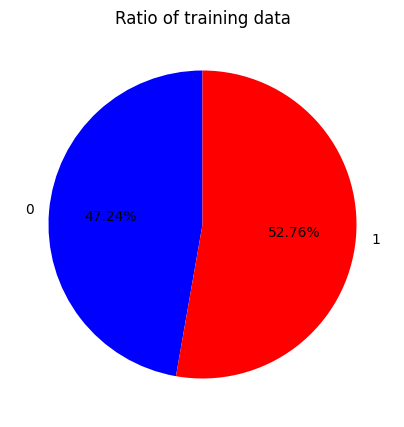

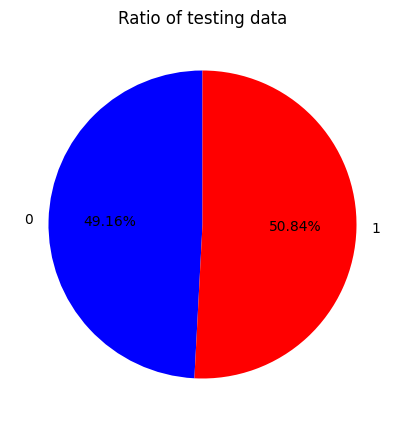

In [29]:
# plot pie chart of class distributions (remember: 1 for bot, 0 for human)
def plot_class_dist(dataframe, title):
    counts = dataframe['BotOrNot'].value_counts().sort_index() # obtain counts of each class
    labels = counts.index.tolist() # obtain labels for each class

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.pie(counts, labels=labels, autopct='%1.2f%%', startangle=90, colors=['b', 'r'])
    ax.set_title(title)
    plt.show()

plot_class_dist(df_train, "Ratio of training data")
plot_class_dist(df_test, "Ratio of testing data")

In [ ]:
# drop target label
X_train = df_train.drop(['BotOrNot'], axis=1).values
y_train = df_train['BotOrNot'].values.reshape(-1,1)
X_test = df_test.drop(['BotOrNot'], axis=1).values
y_test = df_test['BotOrNot'].values.reshape(-1,1)

# take FC dense model and train on Reddit data
training = loaded_model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=20,
    validation_data=(X_test, y_test),
)

Epoch 1/20
23/23 [==============================] - 1s 6ms/step - loss: 1.3874 - accuracy: 0.7358 - val_loss: 0.5523 - val_accuracy: 0.9134
Epoch 2/20
23/23 [==============================] - 0s 2ms/step - loss: 0.3293 - accuracy: 0.9329 - val_loss: 0.2855 - val_accuracy: 0.9525
Epoch 3/20
23/23 [==============================] - 0s 2ms/step - loss: 0.1679 - accuracy: 0.9441 - val_loss: 0.1798 - val_accuracy: 0.9525
Epoch 4/20
23/23 [==============================] - 0s 2ms/step - loss: 0.1217 - accuracy: 0.9497 - val_loss: 0.1513 - val_accuracy: 0.9525
Epoch 5/20
23/23 [==============================] - 0s 2ms/step - loss: 0.1026 - accuracy: 0.9539 - val_loss: 0.1269 - val_accuracy: 0.9581
Epoch 6/20
23/23 [==============================] - 0s 2ms/step - loss: 0.0906 - accuracy: 0.9595 - val_loss: 0.1235 - val_accuracy: 0.9525
Epoch 7/20
23/23 [==============================] - 0s 2ms/step - loss: 0.0833 - accuracy: 0.9644 - val_loss: 0.1137 - val_accuracy: 0.9609
Epoch 8/20
23/23 [==

In [ ]:
# evaluate model on test data
results = loaded_model.evaluate(X_test, y_test)
print(f"Test loss: {results[0]}\tTest acc: {results[1]}\n")

# compare predictions to ground truth (display first 10)
prediction = loaded_model.predict(X_test).ravel()
truth = y_test.ravel()
print("Predictions:", [f"{p:.4f}" for p in prediction[:10]])
print("Ground truth:", [int(t) for t in truth[:10]])
print("\n")

# check model confidence
print("Model confidence:")
for p, t in zip(prediction[:10], truth[:10]):
    print(f"Predicted: {p:.4f} → Label: {int(p >= 0.5)} | Actual: {int(t)}")

12/12 [==============================] - 0s 690us/step - loss: 0.1155 - accuracy: 0.9553
Test loss: 0.11550845950841904	Test acc: 0.9553072452545166

12/12 [==============================] - 0s 566us/step
Predictions: ['0.9999', '0.9964', '0.0000', '0.9999', '0.9700', '0.0000', '0.0283', '0.9987', '0.9999', '0.0000']
Ground truth: [1, 1, 0, 1, 1, 0, 0, 1, 1, 0]


Model confidence:
Predicted: 0.9999 → Label: 1 | Actual: 1
Predicted: 0.9964 → Label: 1 | Actual: 1
Predicted: 0.0000 → Label: 0 | Actual: 0
Predicted: 0.9999 → Label: 1 | Actual: 1
Predicted: 0.9700 → Label: 1 | Actual: 1
Predicted: 0.0000 → Label: 0 | Actual: 0
Predicted: 0.0283 → Label: 0 | Actual: 0
Predicted: 0.9987 → Label: 1 | Actual: 1
Predicted: 0.9999 → Label: 1 | Actual: 1
Predicted: 0.0000 → Label: 0 | Actual: 0


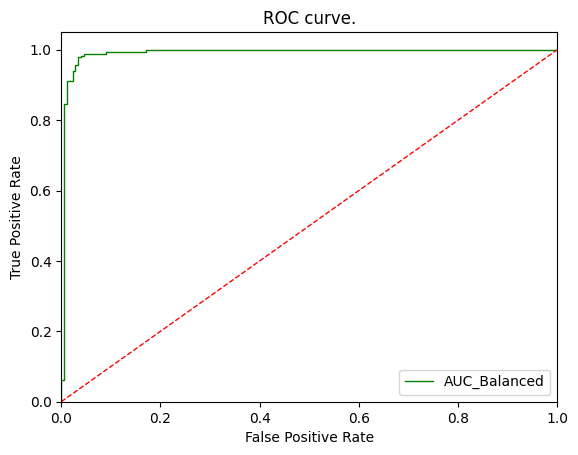

Area under curve: 0.9910


In [ ]:
# create and plot ROC curve and AUC value
fpr, tpr, _ = metrics.roc_curve(y_test.ravel(), prediction) # false pos/true pos rates
auc = metrics.auc(fpr, tpr) # area under curve

plt.plot(
    fpr,
    tpr,
    color= "g",
    lw=1,
    label= "AUC_Balanced",
)

plt.plot([0, 1], [0, 1], color="r", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve.")
plt.legend(loc="lower right")
plt.show()
print(f"Area under curve: {auc:.4f}")

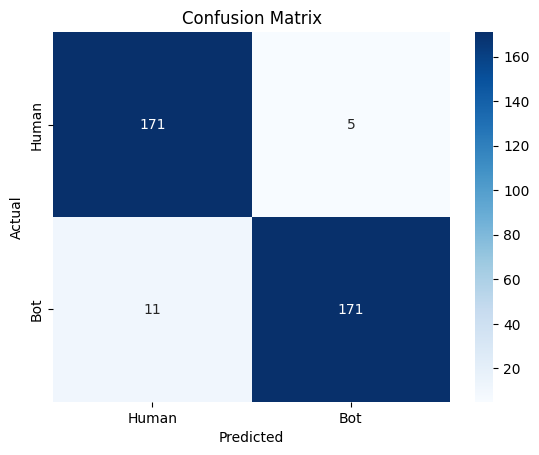

			Classification Report:
              precision    recall  f1-score   support

       Human       0.94      0.97      0.96       176
         Bot       0.97      0.94      0.96       182

    accuracy                           0.96       358
   macro avg       0.96      0.96      0.96       358
weighted avg       0.96      0.96      0.96       358



In [38]:
# create and plot confusion matrix
pred_labels = (prediction >= 0.5).astype(int) # convert prob to binary labels
cm = confusion_matrix(y_test, pred_labels)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=['Human', 'Bot'],
    yticklabels=['Human', 'Bot'],
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# classification report
print("\t\t\tClassification Report:")
print(classification_report(y_test, pred_labels, target_names=['Human', 'Bot']))